<img src="images/OFE-color-horizontal.png" width="150"> &emsp;&emsp; 
<img src="images/OMSF-logo-horizontal-color.png" width="200"> 
# Open Free Energy: An Open Source Ecosystem for Calculating Free Energies

## Introduction to Alchemical Free Energies

The OpenFE ecosystem is an open-source framework for calculating alchemical free energies.


Binding free energies are one metric used to predict which ligand might bind best to a target protein and are often used in **computational drug discovery campaigns**.

This notebook demonstrates how you can use either the **CLI or Python API** to execute physics-based simulations and calculate relative binding free energies (RBFE) for a series of ligands and a given protein. 

- ``.sdf`` format: [chemical data file format](https://en.wikipedia.org/wiki/Chemical_table_file#SDF) used to describe small molecules.
- ``.pdb`` format: [protein data bank](https://www.wwpdb.org/) standardized file format for describing proteins: 


We will be using TYK2 (Tyrosine kinase 2) as our target protein as an example.

For your convenience, a prepared PDB structure of the TYK2 protein is provided in `inputs/tyk2_protein.pdb`:

<center><img src="images/tyk2.png" width="250" alt="TYK2 protein"> </center>

## Alchemical Transformations

For an RBFE calculation, the ligands in our series of candidates must be represented as a **network** that relates the molecules to each other.

Each edge of the network is an ***alchemical*** transformation, "alchemical" because one segment of the molecule (e.g. blue circle) is slowly transformed into another (e.g. green triangle):

For example:

<center> <img src="images/alchemical_transformation.png" width="600"> </center>

OpenFE RBFE calculations can be thought of as 3 distinct steps:

 1. **Setup**: construct a graph relating the ligands
 2. **Run**: execute a physics-based simulation
 3. **Gather**: compute meaningful metrics from the simulation data

Each stage is supported by the OpenFE software packages, but everything can be accessed from the base openfe package, either through the **openfe CLI** or **openfe API**.

<img src="images/ecosystem.png" width="450">

**NOTE**: OpenFE's RBFE protocol uses [OpenMM](https://openmm.org/) as the physics-based simulation engine.
<!-- **NOTE**: OpenFE also provides protocols for running [Absolute Hydration Free Energy Calculations](https://docs.openfree.energy/en/latest/tutorials/ahfe_tutorial.html) and [Molecular Dynamics (MD) simulations](https://docs.openfree.energy/en/latest/tutorials/md_tutorial.html). 
Also, see our [tutorials](https://docs.openfree.energy/en/stable/tutorials/index.html) for step-by-step guides. -->

# 1. Relative Binding Free Energies with the **openfe** CLI

First, we'll demonstrate runing a basic RBFE campaign from the command line (with no Python at all!).

The 3 stages described above each correspond to a CLI command:

**1. setup**:``openfe plan-rbfe-network``

**2. run** ``openfe quickrun``

**3. gather** ``openfe gather``

All you need is your target protein in `.pdb` format, and your candidate ligands in `.sdf` format.

## 1.1 Setup

The `openfe plan-rbfe-network` command plans a relative binding free energy network and saves it as a series of JSON files for the `openfe quickrun` command to process in the "run" stage.

Since the CLI tool is a wrapper intended for the simplest cases, it chooses pratical defaults so that you don't have to define them. 

These choices can be customized by creating a settings yaml file, which is
passed in via the ``-s settings.yaml`` option. For more details, please visit our user guide section about [Customizing CLI planning with YAML settings](https://docs.openfree.energy/en/latest/guide/cli/cli_yaml.html)

In [1]:
# note, we use ligands with charges already assigned to speed up this step,
# but you can run with -M inputs/tyk2_ligands.sdf if you want to charge molecules in real-time
! openfe plan-rbfe-network -M inputs/tyk2_ligands_charged.sdf -p inputs/tyk2_protein.pdb -o tyk2_campaign

RBFE-NETWORK PLANNER
______________________

Parsing in Files: 
	Got input: 
		Small Molecules: SmallMoleculeComponent(name=lig_ejm_31) SmallMoleculeComponent(name=lig_ejm_42) SmallMoleculeComponent(name=lig_ejm_46) SmallMoleculeComponent(name=lig_ejm_43) SmallMoleculeComponent(name=lig_ejm_47) SmallMoleculeComponent(name=lig_ejm_50) SmallMoleculeComponent(name=lig_jmc_23) SmallMoleculeComponent(name=lig_ejm_48) SmallMoleculeComponent(name=lig_jmc_27) SmallMoleculeComponent(name=lig_jmc_28)
		Protein: ProteinComponent(name=)
		Cofactors: []
		Solvent: SolventComponent(name=O, Na+, Cl-)

Using Options:
	Mapper: <KartografAtomMapper-92be13375caab9a5f2ecbf75d925982f>
	Mapping Scorer: <function default_lomap_score at 0x16ea01b20>
	Network Generation: <function generate_minimal_spanning_network at 0x17fa4a2a0>
	Partial Charge Generation: am1bcc

	n_protocol_repeats=3 (3 simulation repeat(s) per transformation)

Planning RBFE-Campaign:
assigning ligand partial charges -- this may be slow
Gen

### visualizing the network

We can visualize the network stored in `ligand_network.graphml` using the `openfe view-ligand-network` command:

(**NOTE**: this will open a new window if running locally, but will not work in Colab. See **3.2 Visualizing a network's edges** for an example of the network plotting Python API)

In [2]:
!openfe view-ligand-network tyk2_campaign/ligand_network.graphml

## 1.2 Run

You can run each leg individually by using the `openfe quickrun` command. It takes a transformation JSON as input, and the flags `-o` to give the final output JSON file and `-d` for the directory where simulation results should be stored. For example,

```bash
openfe quickrun tyk2_json/lig_ejm_31_lig_ejm_47_complex.json -o results_complex.json -d working-directory
openfe quickrun tyk2_json/lig_ejm_31_lig_ejm_47_solvent.json -o results_solvent.json -d working-directory
```

Molecular simulation is time-intensive, so instead of running on high-performance compute, you can copy down example results to explore the next step:

In [3]:
# Results from our cli tutorial
!openfe fetch rbfe-tutorial-results
# Extract results
!tar -xf rbfe_results.tar.gz

Fetching /Users/atravitz/software/openfe/openfecli/tests/data/rbfe_results.tar.gz


For a real study, you would likely use `openfe quickrun` on a HPC using SLURM or a similar scheduler.

## 1.3 Gather

Once the simulations are complete, you can use `openfe gather` to calculate the $\Delta G$ values for each ligand, which can then be ranked to determine the best candidate.

In [4]:
!openfe gather results/ 

Loading results:  ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇  54/54 files
┌────────────┬────────────────────┬────────────────────────┐
│ ligand     │ DG(MLE) (kcal/mol) │ uncertainty (kcal/mol) │
├────────────┼────────────────────┼────────────────────────┤
│ lig_ejm_31 │ -0.09              │ 0.05                   │
│ lig_ejm_42 │ 0.7                │ 0.1                    │
│ lig_ejm_46 │ -0.98              │ 0.05                   │
│ lig_ejm_47 │ -0.1               │ 0.1                    │
│ lig_ejm_48 │ 0.53               │ 0.09                   │
│ lig_ejm_50 │ 0.91               │ 0.06                   │
│ lig_ejm_43 │ 2.0                │ 0.2                    │
│ lig_jmc_23 │ -0.68              │ 0.09                   │
│ lig_jmc_27 │ -1.1               │ 0.1                    │
│ lig_jmc_28 │ -1.25              │ 0.08                   │
└────────────┴────────────────────┴────────────────────────┘


When debugging or trying to understand a dataset better, it can be useful to use the `--report raw` command to show the results for each simulation run for each edge:

In [5]:
!openfe gather results/ --report raw

Loading results:  ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇  54/54 files
┌─────────┬────────────┬────────────┬─────────────────────┬────────────────────┐
│         │            │            │                     │ MBAR uncertainty   │
│ leg     │ ligand_i   │ ligand_j   │ DG(i->j) (kcal/mol) │ (kcal/mol)         │
├─────────┼────────────┼────────────┼─────────────────────┼────────────────────┤
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -14.8               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -14.9               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -15.1               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_46 │ -40.7               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_46 │ -40

# 2. Customizing the **openfe** CLI with a settings YAML

The **openfe** CLI can be customized with the `-s settings.yaml` CLI argument.

For more information see [the CLI settings YAML docs](https://docs.openfree.energy/en/latest/guide/cli/cli_yaml.html).

## 2.1 Choosing a new network generation algorithm

For example, the algorithm used to construct the ligand network can be chosen from:
  - `generate_minimal_spanning_network`: *default*
  - ``generate_minimal_redundant_network``
  - ``generate_radial_network``
  - ``generate_lomap_network``

We'll use a pre-populated settings YAML included in this repo at `inputs/settings_radial.yaml`, which contains settings for using a radial (star) network generator instead of the default MST network generator.

In [6]:
! cat inputs/settings_radial.yaml

network:
  method: generate_radial_network 
  settings:
    central_ligand: lig_jmc_28


In [7]:
! openfe plan-rbfe-network -M inputs/tyk2_ligands_charged.sdf -p inputs/tyk2_protein.pdb -o tyk2_campaign_radial -s inputs/settings_radial.yaml

RBFE-NETWORK PLANNER
______________________

Parsing in Files: 
	Got input: 
		Small Molecules: SmallMoleculeComponent(name=lig_ejm_31) SmallMoleculeComponent(name=lig_ejm_42) SmallMoleculeComponent(name=lig_ejm_46) SmallMoleculeComponent(name=lig_ejm_43) SmallMoleculeComponent(name=lig_ejm_47) SmallMoleculeComponent(name=lig_ejm_50) SmallMoleculeComponent(name=lig_jmc_23) SmallMoleculeComponent(name=lig_ejm_48) SmallMoleculeComponent(name=lig_jmc_27) SmallMoleculeComponent(name=lig_jmc_28)
		Protein: ProteinComponent(name=)
		Cofactors: []
		Solvent: SolventComponent(name=O, Na+, Cl-)

Using Options:
	Mapper: <KartografAtomMapper-92be13375caab9a5f2ecbf75d925982f>
	Mapping Scorer: <function default_lomap_score at 0x30a1fdb20>
	Network Generation: functools.partial(<function generate_radial_network at 0x31894d6c0>, central_ligand='lig_jmc_28')
	Partial Charge Generation: am1bcc

	n_protocol_repeats=3 (3 simulation repeat(s) per transformation)

Planning RBFE-Campaign:
assigning ligand p

In [8]:
!openfe view-ligand-network tyk2_campaign_radial/ligand_network.graphml

# 3. One step further: Using the **openfe** API 

For users who prefer a python API, there are many more ways of customizing **openfe**'s behavior.

Here, we'll repeat the behavior above and generate a radial network, but here you can see how much more flexible the Python interface is.

## 3.1: Using the `ligand_network_planning` API

First, we'll load all the ligands so we can explore the API.

For more about loading ligands and other molecules into **openfe**, see the docs for [Loading Small Molecules](https://docs.openfree.energy/en/latest/cookbook/loading_molecules.html#Loading-small-molecules).

In [9]:
from rdkit import Chem
from gufe import SmallMoleculeComponent

# Load ligands using RDKit
ligands_sdf = Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

Now, we use the `openfe.setup.ligand_network_planning.generate_radial_network` method to create the network.

It takes in ligands from the list we just created, plus an atom mapping, which describes the relationship between two ligands.

You can learn more about atom mappings at [Creating Atom Mappings](https://docs.openfree.energy/en/latest/guide/setup/creating_atom_mappings_and_scores.html#creating-atom-mappings)

<class 'matplotlib.figure.Figure'>


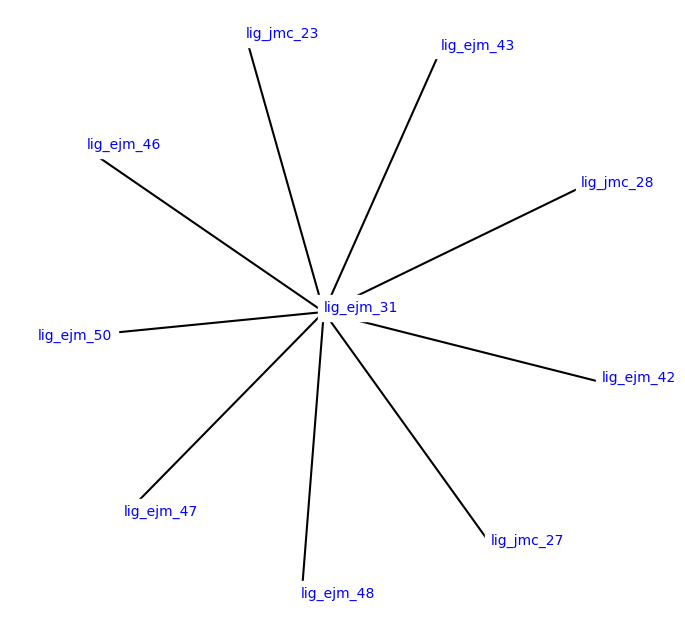

In [10]:
from openfe.setup import ligand_network_planning, LomapAtomMapper
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

radial_network = ligand_network_planning.generate_radial_network(
    central_ligand=ligand_mols[0],  # use the first ligand as the central node
    ligands=ligand_mols[1:],  # use all but the first ligand as the radial ligands
    mappers=[LomapAtomMapper(),],  # this is the default atom mapper
)
plt = plot_atommapping_network(radial_network);

# note that this returns a matplotlib figure for further manipulation
print(type(plt))

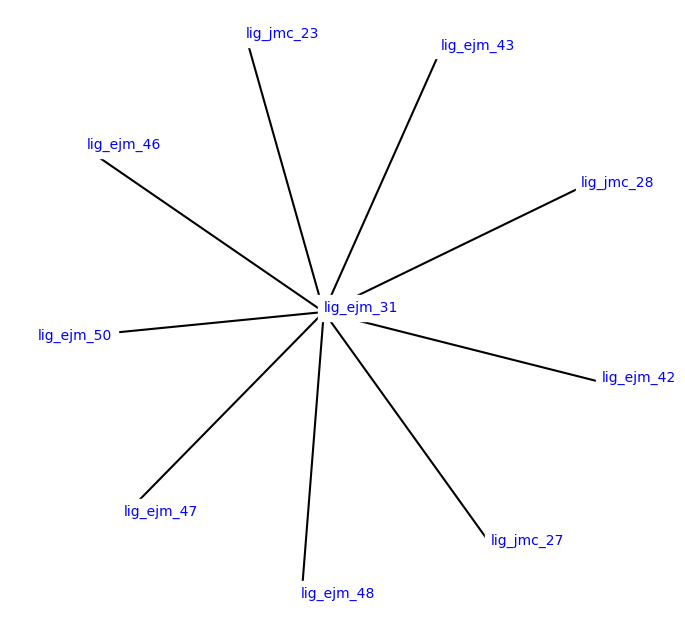

In [11]:
plt

## 3.2: Visualizing a network's edges (`AtomMappings`)

Now, because we are using the Python API, we can more closely inspect the edges of this radial network.

Each edge is an AtomMapping that describes how one molecule can be "alchemically" transformed into the other, as seen here:

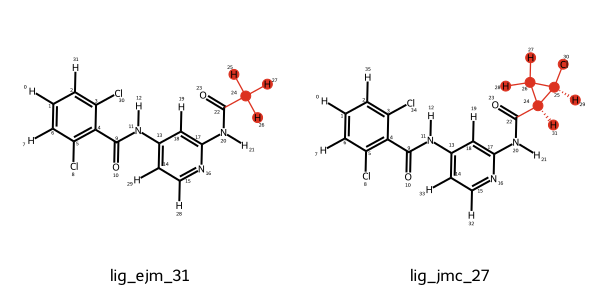

In [12]:
map_31_to_27 = [
    edge for edge in radial_network.edges
    if {edge.componentA.name, edge.componentB.name} == {"lig_ejm_31", "lig_jmc_27"}
][0]

map_31_to_27

Sometimes it can be easier to visualize mappings in 3D using the `view_mapping_3d` method that uses [py3Dmol](https://pypi.org/project/py3Dmol/) as a back-end.

In [13]:
map_31_to_27.view_3d(show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

This is just a small sample of how the API can be used, without even diving into the other sub-projects that make up the OpenFE Ecosystem. 

For example, all of of the nextwork generation shown here is supported by [konnektor](https://konnektor.openfree.energy/). Even more customization can be done at this level, and everything in the OpenFE ecosystem is designed to be interchangeable!


# 4. Useful References for Exploring OpenFE Further

In our [documentation](https://docs.openfree.energy/en/latest/index.html), 
we provide tutorials for ever protocol to walk you through setup, execution and analysis step by step.

* [RBFE CLI tutorial](https://docs.openfree.energy/en/latest/tutorials/rbfe_cli_tutorial.html)
* [RBFE Python tutorial](https://docs.openfree.energy/en/latest/tutorials/rbfe_python_tutorial.html)
* [AHFE tutorial](https://docs.openfree.energy/en/latest/tutorials/ahfe_tutorial.html)
* [MD tutorial](https://docs.openfree.energy/en/latest/tutorials/md_tutorial.html)

In addition to the tutorials, you can find [cookbooks](https://docs.openfree.energy/en/latest/cookbook/index.html), which are how-to guides, as well as a [User Guide](https://docs.openfree.energy/en/latest/guide/index.html) that goes into the underlying concepts of the OpenFE ecosystem.

For details about the ecosystem's core methods and classes, please visit our [API Reference](https://docs.openfree.energy/en/latest/reference/index.html) or our [Github page](https://github.com/OpenFreeEnergy/openfe).

To learn more about the project, our team and how you can get involved, please visit our [Homepage](https://openfree.energy/) or get in touch at OpenFreeEnergy@omsf.io.